# Task 2
#### In this question you will implement and compare the following different KNN variants:
- ##### LSH
- ##### KD-Tree
- ##### Naive Version of KNN
Vary dataset size `N`, number of dimensions `D` to do training and testing time and memory comparison for finding K nearest neighbours. 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage
import psutil

(15, 2)


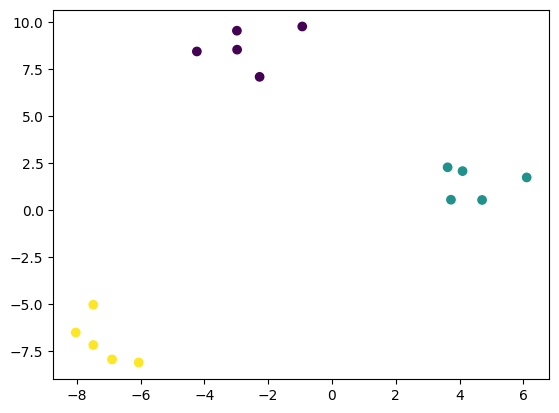

In [ ]:
n_features = 2

def generate_data(N, dimensions, clusters=3):
    X, y = make_blobs(n_samples=N, centers=clusters, n_features=dimensions, random_state=42)
    return X, y

def plot_data(matrix, labels):
    X = matrix[:, 0]
    Y = matrix[:, 1]
    plt.scatter(X, Y, c=labels)

rng = np.random.default_rng(0)

data_size, clusters = generate_data(N = 15, clusters=3, dimensions=n_features)  # testing the function
plot_data(data_size, clusters)
print(data_size.shape)

### LSH 
Locality-sensitive hashing (LSH) is a method that hashes similar data points to have a high chance of being grouped together. This makes LSH a good way to optimize similarity search: by comparing the query data only with a subset of presumably similar items, you can avoid having to sort the entire dataset by some distance metric. The trade-off here is that there is no guarantee for correctness.

In [ ]:
def generate_hyperplanes(dimension, num_planes):
    H = rng.normal(size=(num_planes, dimension + 1))  # hyperplanes as their normal vectors, with extra dimension for bias
    H[:, -1] = 1  # Set the last column to 1 for bias term simplicity
    return H

# Function to track memory usage
def get_memory_usage(dataset, nearest_points, distances):
    # Calculate memory usage of dataset (depends on number of points and dimensions)
    dataset_memory = dataset.nbytes  # This should already scale with both N and D
    
    # Calculate memory for K nearest points and distances
    nearest_points_memory = nearest_points.nbytes 
    distances_memory = distances.nbytes 
    
    # Total memory usage
    total_memory = dataset_memory + nearest_points_memory + distances_memory
    return total_memory

# LSH training and testing function
def train_and_test_lsh(dataset, k=3, num_projections=3):
    n_samples, n_features = dataset.shape
    # Training: Generate random projection matrix and compute hash codes
    start_time = time.time()
    planes = generate_hyperplanes(n_features, num_projections)
    planes[:, -1] = 1                              # Set the last column to 1 for bias term simplicity
    dataset_aug = np.hstack([np.ones((n_samples, 1)), dataset])  # add bias column to dataset
    projections = dataset_aug @ planes.T
    hash_codes = np.sign(projections)  # Calculate hash codes based on the side where the data point lies from the plane 
    train_time = time.time() - start_time  
    
    # Generate a random query point with matching dimension
    query_point = np.random.rand(n_features)
    query_point_aug = np.hstack([1, query_point])  # Augment with bias term
    
    # Testing: Project query point and find nearest neighbors (Brute Force)
    start_time = time.time()
    query_projection = query_point_aug @ planes.T
    query_hash_code = np.sign(query_projection)
    
    # Brute-force Hamming distance calculation: compare all hash codes
    distances = np.sum(np.abs(hash_codes - query_hash_code), axis=1)  # Sum of Hamming distances
    nearest_indices = np.argsort(distances)[:k]  # Get indices of k-nearest points (brute force)
    
    test_time = time.time() - start_time  # Measure testing time
    
    # Calculate memory usage
    total_memory = get_memory_usage(dataset, hash_codes, distances)
    
    return train_time, test_time, total_memory


In [ ]:
num_samples_list = list(range(500, 10000, 500))
num_dimensions_list = list(range(2, 10))

# Collect training and testing times and memory usage for size and dimension variations
train_times_size, test_times_size, total_mem_size = [], [], []
train_times_dim, test_times_dim, total_mem_dim = [], [], []

print("Varying dataset sample size:", num_samples_list)
for N in num_samples_list:
    data_size, clusters = generate_data(N, dimensions=10)
    train_time, test_time, total_memory = train_and_test_lsh(data_size, k=3, num_projections=3)
    train_times_size.append(train_time)
    test_times_size.append(test_time)
    total_mem_size.append(total_memory)

print("Varying dataset dimensions:", num_dimensions_list)
for D in num_dimensions_list:
    data_dim, clusters = generate_data(10000, dimensions=D)
    train_time, test_time, total_memory = train_and_test_lsh(data_dim, k=3, num_projections=3)
    train_times_dim.append(train_time)
    test_times_dim.append(test_time)
    total_mem_dim.append(total_memory)


print("timing the function with timeit:")
data_size, clusters = generate_data(500, dimensions=10)
print("With 500 samples and 10 dimensions")
%timeit train_and_test_lsh(data_size, k=3, num_projections=3)
data_size, clusters = generate_data(5000, dimensions=10)
print("With 5000 samples and 10 dimensions")
%timeit train_and_test_lsh(data_size, k=3, num_projections=3)
data_size, clusters = generate_data(10000, dimensions=10)
print("With 10000 samples and 10 dimensions")
%timeit train_and_test_lsh(data_size, k=3, num_projections=3)

Varying dataset sample size: [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500]
Varying dataset dimensions: [2, 3, 4, 5, 6, 7, 8, 9]
timing the function with timeit:
With 500 samples and 10 dimensions
102 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
With 5000 samples and 10 dimensions
1.27 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
With 10000 samples and 10 dimensions
2.43 ms ± 42.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


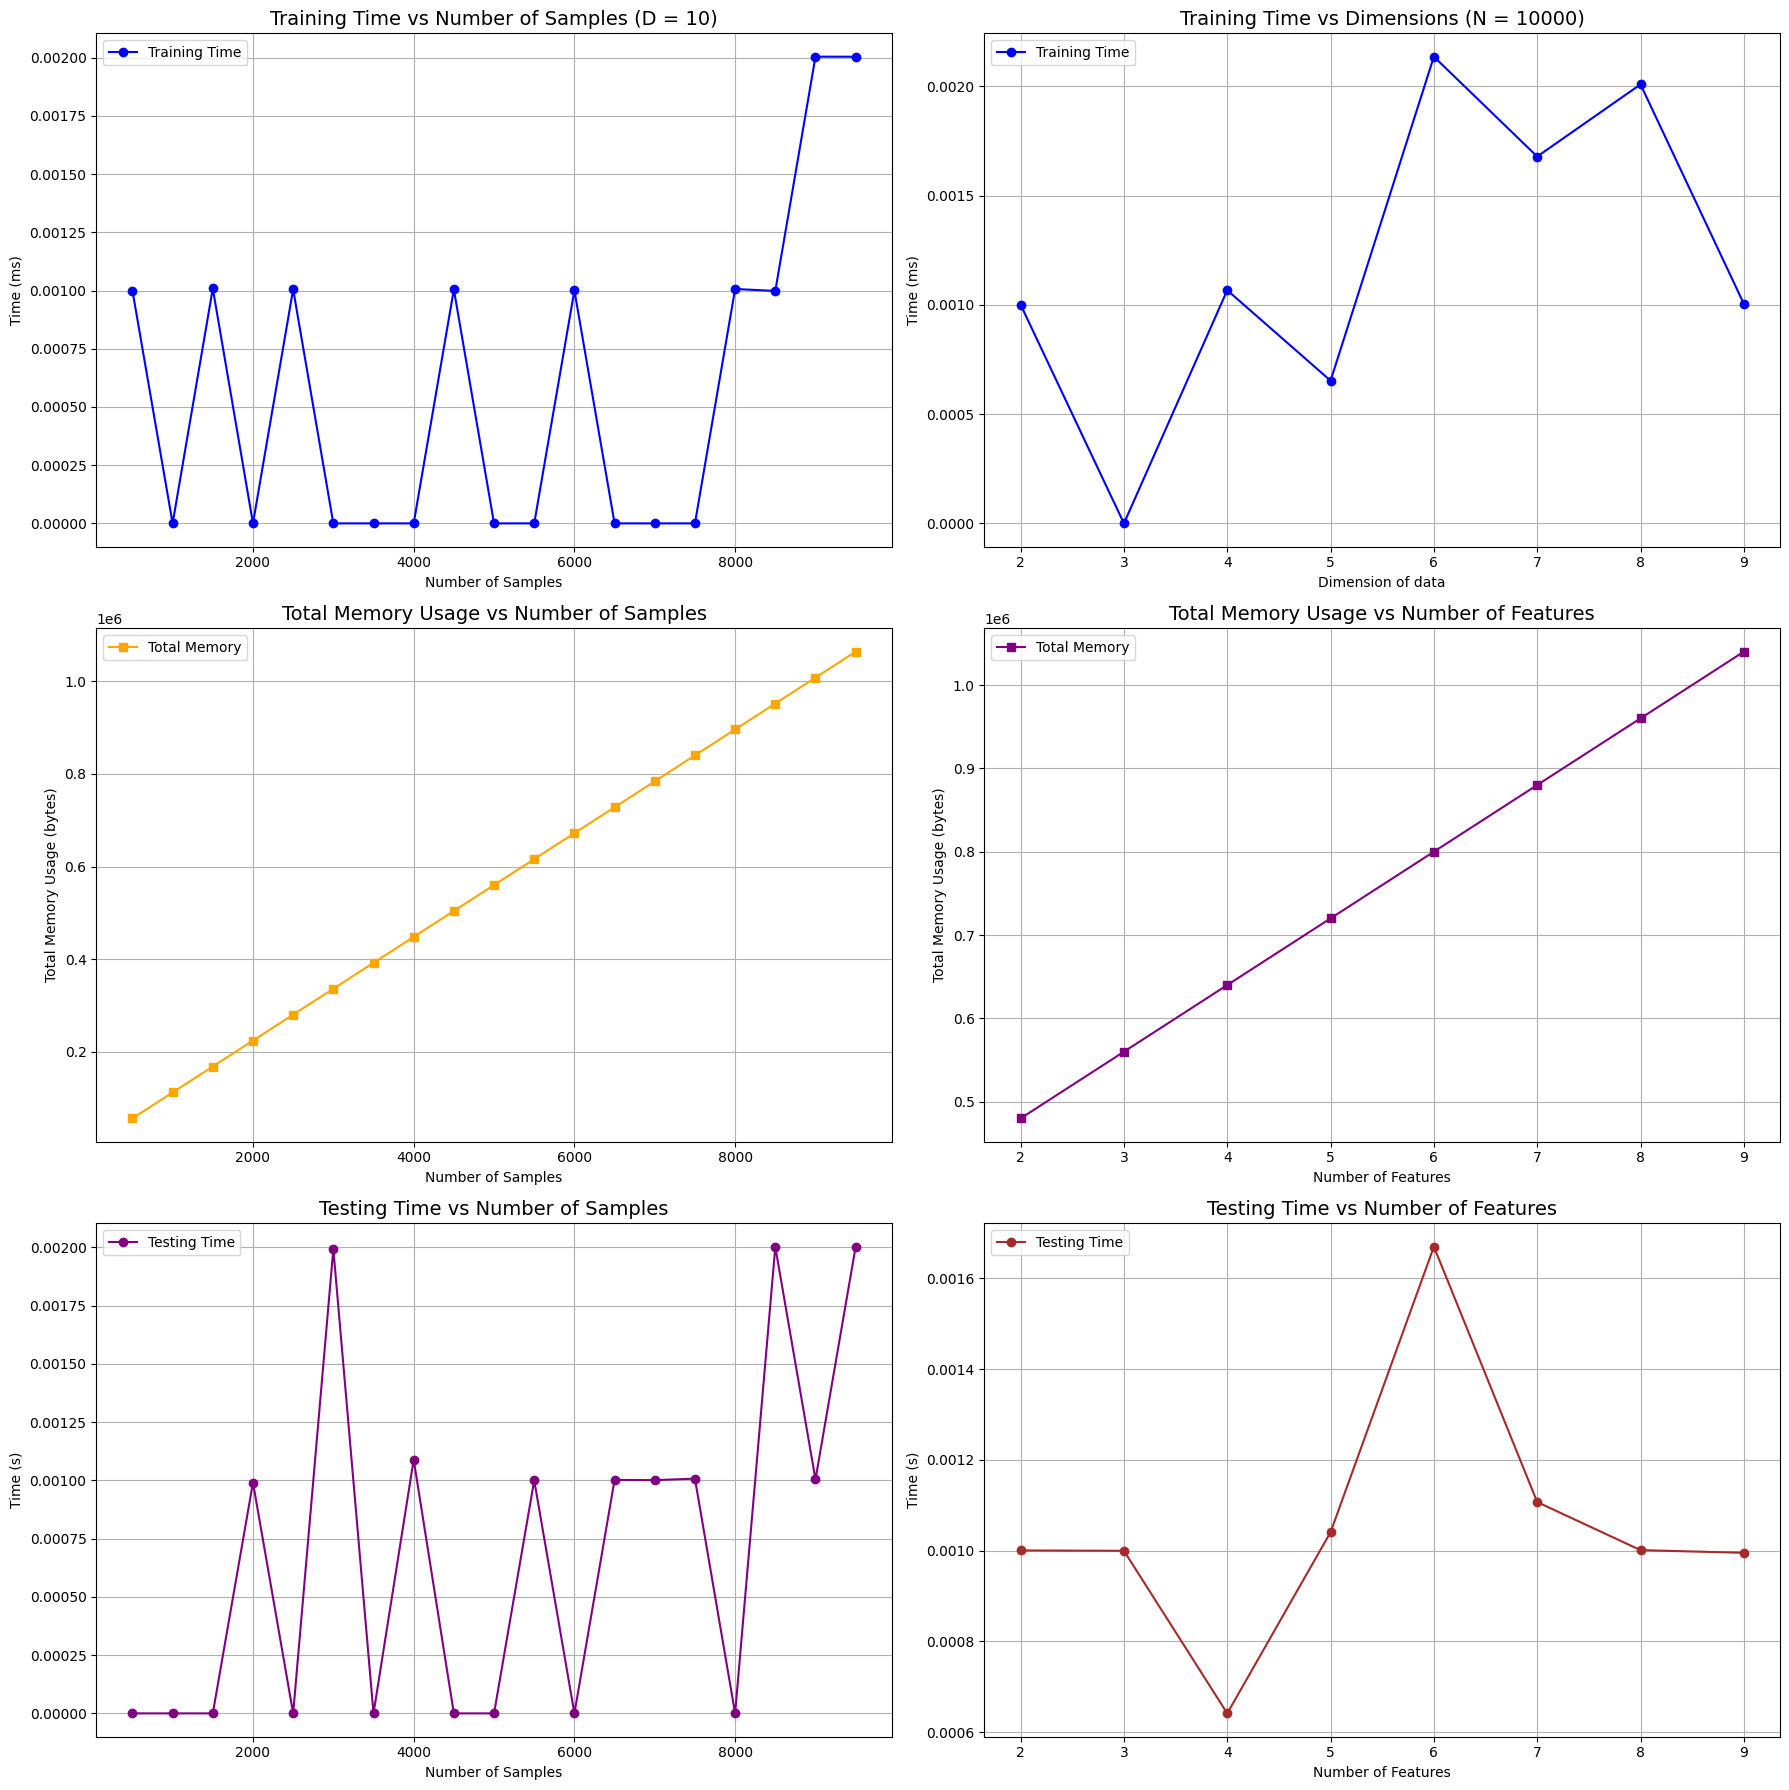

In [ ]:
plt.figure(figsize=(18, 18))
# Top row - Training and Testing Times by Size and Dimension
plt.subplot(3, 2, 1)
plt.plot(num_samples_list, train_times_size , label="Training Time", color='b', marker='o')
plt.xlabel("Number of Samples")
plt.ylabel("Time (ms)")
plt.title("Training Time vs Number of Samples (D = 10)", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(num_dimensions_list, train_times_dim , label="Training Time", color='b', marker='o')
plt.xlabel("Dimension of data")
plt.ylabel("Time (ms)")
plt.title("Training Time vs Dimensions (N = 10000)", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Second row - Total Memory Usage by Dataset Size and Dataset Dimension
plt.subplot(3, 2, 3)
plt.plot(num_samples_list, total_mem_size, label="Total Memory", color='orange', marker='s')
plt.xlabel("Number of Samples")
plt.ylabel("Total Memory Usage (bytes)")
plt.title("Total Memory Usage vs Number of Samples", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(num_dimensions_list, total_mem_dim, label="Total Memory", color='purple', marker='s')
plt.xlabel("Number of Features")
plt.ylabel("Total Memory Usage (bytes)")
plt.title("Total Memory Usage vs Number of Features", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Third row - Testing Times by Size and Dimension
plt.subplot(3, 2, 5)
plt.plot(num_samples_list, test_times_size, label="Testing Time", color='purple', marker='o')
plt.xlabel("Number of Samples")
plt.ylabel("Time (s)")
plt.title("Testing Time vs Number of Samples", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(num_dimensions_list, test_times_dim, label="Testing Time", color='brown', marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Time (s)")
plt.title("Testing Time vs Number of Features", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Bottom row - Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()

### Time and Memory Complexity of LSH

- **Training Time**:  
  Training involves hashing \(n\) data points with \(k\) hash functions, each taking \(O(d)\) for projection. Hence, the training time complexity is:
  $$
  O(n \cdot k \cdot d)
  $$

- **Testing Time**:  
  Testing involves hashing the query point with \(k\) hash functions (\(O(d)\) time), followed by checking all \(n\) data points. The testing time complexity is:
  $$
  O(k \cdot d + n)
  $$

- **Memory Complexity**:  
  Memory is used to store the hash codes of \(n\) data points, each requiring \(O(k)\) space. The memory complexity is:
  $$
  O(n \cdot k)
  $$

Where:
- \(n\) = number of data points,
- \(k\) = number of hash functions,
- \(d\) = dimensionality of the data.

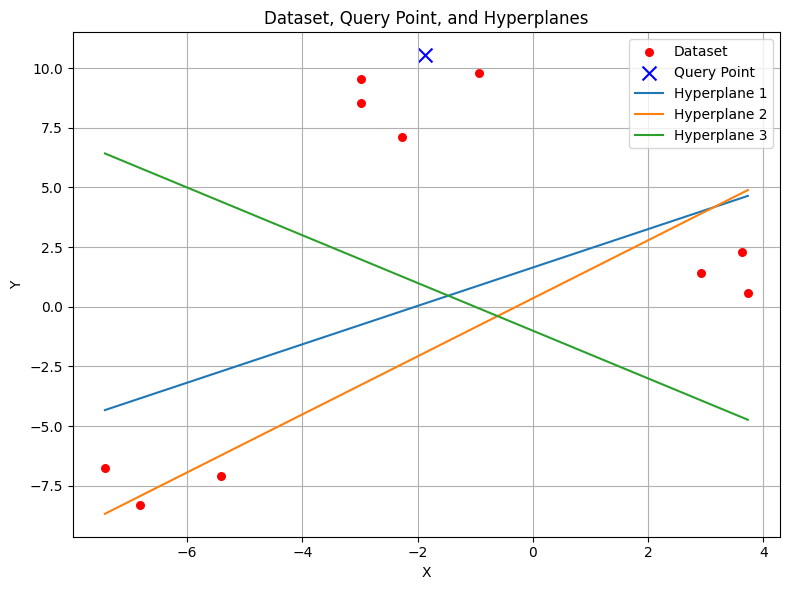

In [ ]:
# Set random seed for reproducibility
np.random.seed(35)

# Define the dataset
dataset_2d, clusters = generate_data(10, 2, 3)
query_point, cluster = make_blobs(n_samples=1, centers=1, n_features=2, random_state=42)

# Number of hyperplanes
P = 3  

# Random coefficients for the hyperplanes, with one extra row for intercept
R = np.random.randn(3, P)
R[:, 2] = 1  # Set the third column's third row to 1 to simplify plotting

# Plotting the dataset and query point
plt.figure(figsize=(8, 6))

# Plot the dataset points
plt.scatter(dataset_2d[:, 0], dataset_2d[:, 1], color="red", label="Dataset", s=30)

# Plot the query point
plt.scatter(query_point[0][0], query_point[0][1], color="blue", label="Query Point", marker='x', s=100)

# Plot the hyperplanes
x_range = np.array([dataset_2d[:, 0].min(), dataset_2d[:, 0].max()])  # x-axis range based on data
for i in range(P):
    # Calculate corresponding y-values for the hyperplane
    x2 = (-R[0, i] - R[1, i] * x_range) / R[2, i]
    plt.plot(x_range, x2, label=f'Hyperplane {i+1}')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dataset, Query Point, and Hyperplanes')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()